In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV

from auxiliary import plot_cm, plot_nn_metrics, plot_roc, save_metrics, drop_var_nonobj, drop_var_obj

import os
import tempfile

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
#Change path according to directory used
path = r'C:\Users\henri\OneDrive\Documentos\EDSA\EDS Bootcamp\Project\Data\HR_DS.csv'
df = pd.read_csv(path)

In [3]:
# Remove non object variables with no variability
drop_var_nonobj(df)

2 columns, ['EmployeeCount', 'StandardHours'] were droped


In [4]:
# Remove object variables with no variability
drop_var_obj(df)

The ['Over18'] column was droped.


In [5]:
objects = df.describe(include='O').columns.tolist()
non_objs = df.describe().columns.tolist()

patterns = [' ', 'Travel_', '-', '&']

for p in patterns:
    df[objects] = df[objects].apply(lambda x: x.str.replace(p, ''))
    print('Pattern "{}" cleared.'.format(p))

Pattern " " cleared.
Pattern "Travel_" cleared.
Pattern "-" cleared.
Pattern "&" cleared.


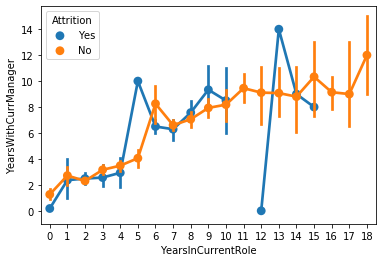

In [6]:
sb.pointplot(df.YearsInCurrentRole, df.YearsWithCurrManager, hue=df.Attrition)
plt.show()

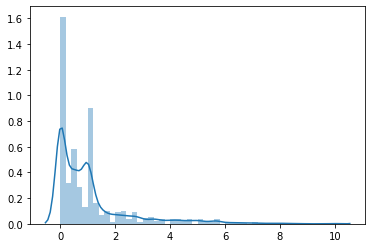

In [7]:
sb.distplot((df.TotalWorkingYears-df.YearsAtCompany)/(df.NumCompaniesWorked+1))
plt.show()

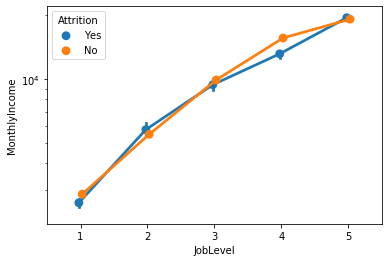

In [8]:
sb.pointplot(df.JobLevel, df.MonthlyIncome, hue=df.Attrition, dodge=True)
plt.yscale('log')
plt.show()

In [9]:
# Score that evaluates the number of years per companies
# The lower the score, the less stable/unexperienced the employee is
# The higher the score, the most stable/experienced the employee it
df['StayScore']=((df.TotalWorkingYears-df.YearsAtCompany)/(df.NumCompaniesWorked+1))

In [10]:
df.StayScore.describe()

count    1470.000000
mean        1.035314
std         1.430512
min         0.000000
25%         0.000000
50%         0.600000
75%         1.000000
max        10.000000
Name: StayScore, dtype: float64

In [11]:
df.drop(columns=['JobLevel', 'EmployeeNumber', 'TotalWorkingYears', 'NumCompaniesWorked'], inplace=True)

In [12]:
objects = df.describe(include='O').columns.tolist()
non_objs = df.describe().columns.tolist()

depois do spit

In [13]:
minmax = MinMaxScaler()
df_pre_ss = pd.concat([df[objects], pd.DataFrame(minmax.fit_transform(df[non_objs]), columns=df[non_objs].columns)], axis=1, sort=False)

Making some dummies

In [14]:
finaldf = pd.get_dummies(df_pre_ss, drop_first=True)

In [15]:
n_features = len(finaldf.columns)
n_features

43

# Models Testing (Train, Val, Test)
First, the dataset has to be split into 3 sets of data so that the following is available for every model:
* A train dataset (features and labels appart) (80%)
* A validation dataset (features and labels appart) (10%)
    * Will be used to validate the train dataset
* A test dataset (features and labels appart) (10%)
    * Will be used to test the final models as an out of sample dataset.
    
Further on, the models will be evaluated on using Stratified K Fold Testing (90% to 10%)

In [16]:
# test 10%; val 10%; train 80%
train_df, test_df = train_test_split(finaldf, test_size=0.1, random_state=123, stratify=finaldf.Attrition_Yes)

# Form np arrays of labels and features
train_labels = np.array(train_df.pop('Attrition_Yes'))
bool_train_labels = train_labels != 0
test_labels = np.array(test_df.pop('Attrition_Yes'))

train_features = np.array(train_df)
test_features = np.array(test_df)

print('Training labels shape:', train_labels.shape)
print('Test labels shape:', test_labels.shape)
print('')
print('Training features shape:', train_features.shape)
print('Test features shape:', test_features.shape)

Training labels shape: (1323,)
Test labels shape: (147,)

Training features shape: (1323, 42)
Test features shape: (147, 42)


A check on the imbalance of the datasets is needed

In [17]:
neg, pos = np.bincount(finaldf.Attrition_Yes)
total = neg + pos
print('Cases on full dataset:\n    Total: {}\n    Employees that Left the company: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Cases on full dataset:
    Total: 1470
    Employees that Left the company: 237 (16.12% of total)



In [18]:
neg, pos = np.bincount(test_labels)
total = neg + pos
print('Cases on test dataset:\n    Total: {}\n    Employees that Left the company: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Cases on test dataset:
    Total: 147
    Employees that Left the company: 24 (16.33% of total)



In [19]:
neg, pos = np.bincount(train_labels)
total = neg + pos
print('Cases on training dataset:\n    Total: {}\n    Employees that Left the company: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Cases on training dataset:
    Total: 1323
    Employees that Left the company: 213 (16.10% of total)



A determination of the weights of the target label will be important further on the testing of the models

In [20]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg)*(total)/2
weight_for_1 = (1 / pos)*(total)/2

class_weights = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0 (Stayers): {:.2f}'.format(weight_for_0))
print('Weight for class 1 (Leavers): {:.2f}'.format(weight_for_1))

Weight for class 0 (Stayers): 0.60
Weight for class 1 (Leavers): 3.11


In [21]:
# initialization of the dataframe to store the metrics for each model evaluated on test split
models_summary = pd.DataFrame(columns=['model','tp', 'fp', 'tn', 'fn', 
                                       'acc', 'prec', 'recall', 'auc', 'f1', 'mc_coef', 
                                       'batch_s'])

TODO

Distribution probability?!?!?!?!?!?

Precision recall curve or ROC curve?

sampling ratio

SMOTE

## 1. XDBoost

In [22]:
from xgboost import XGBClassifier
# https://machinelearningmastery.com/develop-first-xgboost-model-python-scikit-learn/

### GridSearch with Stratified K-Fold CV

In [23]:
# fit model on training data
m_XGB = XGBClassifier(n_jobs=6, learning_rate=0.01, scale_pos_weight=pos/neg)

#model_XGB.fit(train_features, train_labels,
#          eval_set=[(train_features, train_labels), (val_features, val_labels)],
#          eval_metric='auc',
#          verbose=False)

parameters = {'objective':['binary:logistic'],
              'learning_rate': [0.01, 0.05, 0.1],
              'max_depth': [i for i in range(5,10)],
              'subsample': [0.5, 1],
              'colsample_bytree': [0.5, 1],
              'n_estimators': [100, 1000],
              'seed': [123]}

grid_s = GridSearchCV(m_XGB, parameters, n_jobs=6,
                      cv=StratifiedKFold(n_splits=5, shuffle=True),
                      scoring='f1',
                      verbose=2, refit=True)

grid_s.fit(train_features, train_labels)
print(grid_s.best_estimator_)
model_XGB = grid_s.best_estimator_

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:    5.4s
[Parallel(n_jobs=6)]: Done 150 tasks      | elapsed:   26.2s
[Parallel(n_jobs=6)]: Done 353 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done 600 out of 600 | elapsed:  2.1min finished


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=6,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=0.1918918918918919,
              seed=123, silent=None, subsample=0.5, verbosity=1)


In [24]:
models_summary = save_metrics(models_summary, model_XGB, test_labels, model_XGB.predict_proba(test_features)[:, 1])
models_summary

,model,tp,fp,tn,fn,acc,prec,recall,auc,f1,mc_coef,batch_s
0,"XGBClassifier(base_score=0.5, booster='gbtree'...",7,2,121,17,0.870748,0.777778,0.291667,0.811314,0.424242,0.424592,NaN


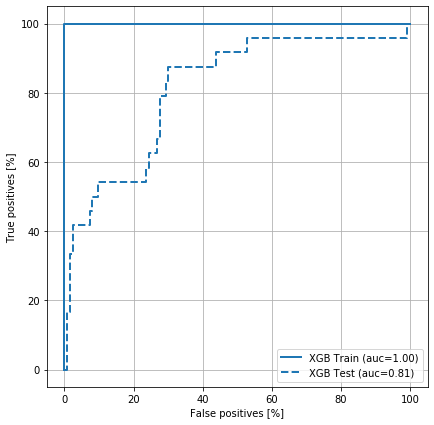

Stayers Detected (True Negatives):  121
Stayers Missed (False Positives):  2
Leavers Missed (False Negatives):  17
Leavers Detected (True Positives):  7


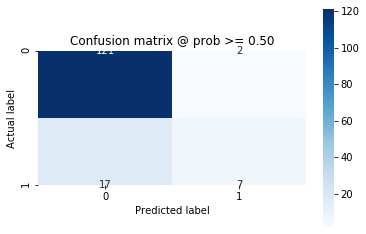

In [25]:
plt.figure(figsize=(7, 7))
plot_roc("XGB Train", train_labels, model_XGB.predict_proba(train_features)[:, 1], lcolor=colors[0])
plot_roc("XGB Test", test_labels, model_XGB.predict_proba(test_features)[:, 1], lcolor=colors[0], lstyle='--')
plt.legend(loc='lower right')
plt.show()
plot_cm(test_labels, model_XGB.predict_proba(test_features)[:, 1])

## 2. Logistic Regression

In [26]:
from sklearn.linear_model import LogisticRegression as LR

### GridSearch with Stratified K-Fold CV

In [27]:
m_log = LR(class_weight=class_weights,
                     random_state=0,
                     multi_class='ovr',
                     n_jobs=6)

parameters = [{'solver' : ['sag'],
              'C' : [1, 10, 100],
              'max_iter': [10000],
              'penalty' : ('none', 'l2'),
              'warm_start' : (True, False),
              'fit_intercept' : [True, False]},
              {'solver' : ['liblinear', 'saga'], 
              'C' : [1, 10, 100],
              'max_iter': [10000],
              'penalty' : ('l1', 'l2'),
              'warm_start' : (True, False),
              'fit_intercept' : [True, False]}]

grid_s = sklearn.model_selection.GridSearchCV(m_log, parameters, n_jobs=6, 
                                              cv=StratifiedKFold(n_splits=5, 
                                                                 shuffle=True),
                                              scoring='f1',
                                              refit=True,
                                              verbose=1)
grid_s.fit(train_features, train_labels)
print(grid_s.best_estimator_)
model_logistic = grid_s.best_estimator_

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    3.4s
[Parallel(n_jobs=6)]: Done 314 tasks      | elapsed:   14.5s
[Parallel(n_jobs=6)]: Done 349 out of 360 | elapsed:   15.7s remaining:    0.4s


LogisticRegression(C=1,
                   class_weight={0: 0.595945945945946, 1: 3.1056338028169015},
                   dual=False, fit_intercept=True, intercept_scaling=1,
                   l1_ratio=None, max_iter=10000, multi_class='ovr', n_jobs=6,
                   penalty='l2', random_state=0, solver='sag', tol=0.0001,
                   verbose=0, warm_start=True)


[Parallel(n_jobs=6)]: Done 360 out of 360 | elapsed:   16.1s finished


In [28]:
models_summary = save_metrics(models_summary, model_logistic, test_labels, model_logistic.predict_proba(test_features)[:,1])
models_summary.sort_values(by=['mc_coef', 'auc', 'prec'], ascending=False)

,model,tp,fp,tn,fn,acc,prec,recall,auc,f1,mc_coef,batch_s
0,"XGBClassifier(base_score=0.5, booster='gbtree'...",7,2,121,17,0.870748,0.777778,0.291667,0.811314,0.424242,0.424592,NaN
1,"LogisticRegression(C=1,\n cl...",16,30,93,8,0.741497,0.347826,0.666667,0.847222,0.457143,0.336990,NaN


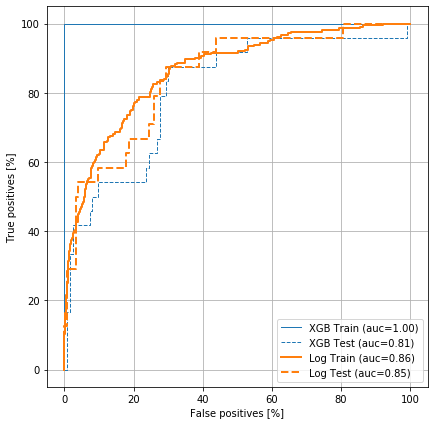

Stayers Detected (True Negatives):  93
Stayers Missed (False Positives):  30
Leavers Missed (False Negatives):  8
Leavers Detected (True Positives):  16


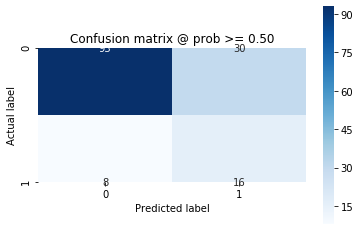

In [29]:
plt.figure(figsize=(7, 7))
plot_roc("XGB Train", train_labels, model_XGB.predict_proba(train_features)[:, 1], lcolor=colors[0], lwidth=1)
plot_roc("XGB Test", test_labels, model_XGB.predict_proba(test_features)[:, 1], lcolor=colors[0], lstyle='--', lwidth=1)

plot_roc("Log Train", train_labels, model_logistic.predict_proba(train_features)[:, 1], lcolor=colors[1])
plot_roc("Log Test", test_labels, model_logistic.predict_proba(test_features)[:, 1], lcolor=colors[1], lstyle='--')
plt.legend(loc='lower right')
plt.show()
plot_cm(test_labels, model_logistic.predict_proba(test_features)[:, 1])

## 3. LinearSVC

In [30]:
from sklearn.svm import LinearSVC as LSVC

### GridSearch with Stratified K-Fold CV

In [31]:
m_LinearSVC = LSVC(dual=False,
                   loss = 'squared_hinge',
                   tol=0.0001, 
                   multi_class='ovr', 
                   fit_intercept=True, 
                   intercept_scaling=1, 
                   class_weight=class_weights, 
                   random_state=0)

parameters = [{'C' : [i for i in range(1,10,2)],
               'penalty' : ['l1', 'l2'],
               'max_iter': [10000, 100000, 1000000]}]

grid_s = sklearn.model_selection.GridSearchCV(m_LinearSVC, parameters, n_jobs=6,
                                              cv=StratifiedKFold(n_splits=5, 
                                                                 shuffle=True),
                                              scoring='f1',
                                              refit=True,
                                              verbose=1)
grid_s.fit(train_features, train_labels)
print(grid_s.best_estimator_)
model_LinearSVC = grid_s.best_estimator_

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    2.7s
[Parallel(n_jobs=6)]: Done 150 out of 150 | elapsed:    9.7s finished


LinearSVC(C=1, class_weight={0: 0.595945945945946, 1: 3.1056338028169015},
          dual=False, fit_intercept=True, intercept_scaling=1,
          loss='squared_hinge', max_iter=10000, multi_class='ovr', penalty='l1',
          random_state=0, tol=0.0001, verbose=0)


In [32]:
models_summary = save_metrics(models_summary, model_LinearSVC, test_labels, model_LinearSVC.decision_function(test_features))
models_summary.sort_values(by=['f1', 'auc', 'prec'], ascending=False)

,model,tp,fp,tn,fn,acc,prec,recall,auc,f1,mc_coef,batch_s
2,"LinearSVC(C=1, class_weight={0: 0.595945945945...",11,4,119,13,0.884354,0.733333,0.458333,0.848238,0.564103,0.519930,NaN
1,"LogisticRegression(C=1,\n cl...",16,30,93,8,0.741497,0.347826,0.666667,0.847222,0.457143,0.336990,NaN
0,"XGBClassifier(base_score=0.5, booster='gbtree'...",7,2,121,17,0.870748,0.777778,0.291667,0.811314,0.424242,0.424592,NaN


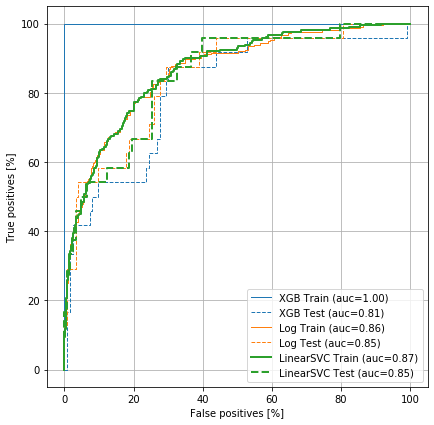

Stayers Detected (True Negatives):  119
Stayers Missed (False Positives):  4
Leavers Missed (False Negatives):  13
Leavers Detected (True Positives):  11


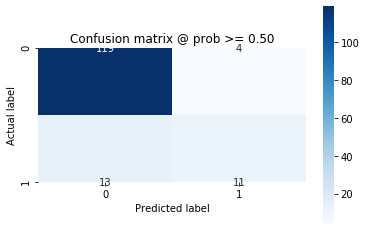

In [33]:
plt.figure(figsize=(7, 7))
plot_roc("XGB Train", train_labels, model_XGB.predict_proba(train_features)[:, 1], lcolor=colors[0], lwidth=1)
plot_roc("XGB Test", test_labels, model_XGB.predict_proba(test_features)[:, 1], lcolor=colors[0], lstyle='--', lwidth=1)

plot_roc("Log Train", train_labels, model_logistic.predict_proba(train_features)[:, 1], lcolor=colors[1], lwidth=1)
plot_roc("Log Test", test_labels, model_logistic.predict_proba(test_features)[:, 1], lcolor=colors[1], lstyle='--', lwidth=1)

plot_roc("LinearSVC Train", train_labels, model_LinearSVC.decision_function(train_features), lcolor=colors[2])
plot_roc("LinearSVC Test", test_labels, model_LinearSVC.decision_function(test_features), lcolor=colors[2], lstyle='--')
plt.legend(loc='lower right')
plt.show()

plot_cm(test_labels, model_LinearSVC.decision_function(test_features))

## 4. SVC

In [34]:
from sklearn.svm import SVC

### GridSearch with Stratified K-Fold CV

In [35]:
m_SVC = SVC(probability=True, 
            tol=0.001, 
            cache_size=200,
            decision_function_shape='ovr',
            class_weight=class_weights,
            random_state=0,
            max_iter=5000)

parameters = [{'kernel' : ['rbf', 'linear', 'poly', 'sigmoid'],
               'C' : [i for i in range(1,10,2)],
               'gamma' : [1, 0.1],
               'coef0' : [1, 0.1],
               'shrinking' : [True, False]}]

grid_s = sklearn.model_selection.GridSearchCV(m_SVC, parameters, n_jobs=6,
                                              cv=StratifiedKFold(n_splits=5, 
                                                                 shuffle=True),
                                              scoring='f1',
                                              refit=True,
                                              verbose=1)
grid_s.fit(train_features, train_labels)
print(grid_s.best_estimator_)
model_SVC = grid_s.best_estimator_

Fitting 5 folds for each of 160 candidates, totalling 800 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    4.0s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:   11.6s
[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed:   24.8s
[Parallel(n_jobs=6)]: Done 788 tasks      | elapsed:   42.8s
[Parallel(n_jobs=6)]: Done 800 out of 800 | elapsed:   43.2s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


SVC(C=7, cache_size=200,
    class_weight={0: 0.595945945945946, 1: 3.1056338028169015}, coef0=1,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='linear',
    max_iter=5000, probability=True, random_state=0, shrinking=True, tol=0.001,
    verbose=False)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


In [36]:
models_summary = save_metrics(models_summary, model_SVC, test_labels, model_SVC.predict_proba(test_features)[:, 1])
models_summary.sort_values(by=['mc_coef', 'auc', 'prec'], ascending=False)

,model,tp,fp,tn,fn,acc,prec,recall,auc,f1,mc_coef,batch_s
2,"LinearSVC(C=1, class_weight={0: 0.595945945945...",11,4,119,13,0.884354,0.733333,0.458333,0.848238,0.564103,0.519930,NaN
0,"XGBClassifier(base_score=0.5, booster='gbtree'...",7,2,121,17,0.870748,0.777778,0.291667,0.811314,0.424242,0.424592,NaN
3,"SVC(C=7, cache_size=200,\n class_weight={0:...",6,1,122,18,0.870748,0.857143,0.250000,0.840447,0.387097,0.419785,NaN
1,"LogisticRegression(C=1,\n cl...",16,30,93,8,0.741497,0.347826,0.666667,0.847222,0.457143,0.336990,NaN


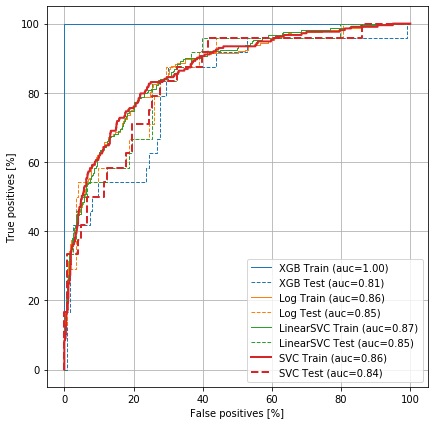

Stayers Detected (True Negatives):  122
Stayers Missed (False Positives):  1
Leavers Missed (False Negatives):  18
Leavers Detected (True Positives):  6


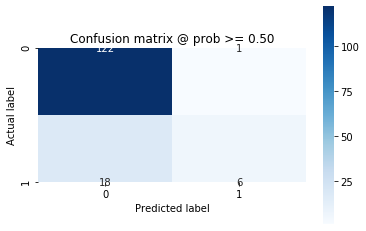

In [37]:
plt.figure(figsize=(7, 7))
plot_roc("XGB Train", train_labels, model_XGB.predict_proba(train_features)[:, 1], lcolor=colors[0], lwidth=1)
plot_roc("XGB Test", test_labels, model_XGB.predict_proba(test_features)[:, 1], lcolor=colors[0], lstyle='--', lwidth=1)

plot_roc("Log Train", train_labels, model_logistic.predict_proba(train_features)[:, 1], lcolor=colors[1], lwidth=1)
plot_roc("Log Test", test_labels, model_logistic.predict_proba(test_features)[:, 1], lcolor=colors[1], lstyle='--', lwidth=1)

plot_roc("LinearSVC Train", train_labels, model_LinearSVC.decision_function(train_features), lcolor=colors[2], lwidth=1)
plot_roc("LinearSVC Test", test_labels, model_LinearSVC.decision_function(test_features), lcolor=colors[2], lstyle='--', lwidth=1)

plot_roc("SVC Train", train_labels, model_SVC.predict_proba(train_features)[:, 1], lcolor=colors[3])
plot_roc("SVC Test", test_labels, model_SVC.predict_proba(test_features)[:, 1], lcolor=colors[3], lstyle='--')
plt.legend(loc='lower right')
plt.show()

plot_cm(test_labels, model_SVC.predict_proba(test_features)[:, 1])

## 5. Radius Neighbors Classifier

In [38]:
from sklearn.neighbors import RadiusNeighborsClassifier as RadiusNC

### GridSearch with Stratified K-Fold CV

In [39]:
m_RadiusNC = RadiusNC(algorithm='auto',
                      n_jobs=-1)

parameters = [{'radius' : [i for i in range(9, 30, 2)],
               'leaf_size' : [i for i in range(5, 40, 5)],
               'weights' : ['uniform', 'distance'],
               'p' : [1, 2, 3]}]

grid_s = sklearn.model_selection.GridSearchCV(m_RadiusNC, parameters, n_jobs=6,
                                              cv=StratifiedKFold(n_splits=5, 
                                                                 shuffle=True),
                                              scoring='f1',
                                              refit=True,
                                              verbose=1)
grid_s.fit(train_features, train_labels)
print(grid_s.best_estimator_)
model_RadiusNC = grid_s.best_estimator_

Fitting 5 folds for each of 462 candidates, totalling 2310 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    2.4s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:    5.9s
[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed:   12.9s
[Parallel(n_jobs=6)]: Done 788 tasks      | elapsed:   22.2s
[Parallel(n_jobs=6)]: Done 1238 tasks      | elapsed:   34.2s
[Parallel(n_jobs=6)]: Done 1788 tasks      | elapsed:   48.9s


RadiusNeighborsClassifier(algorithm='auto', leaf_size=5, metric='minkowski',
                          metric_params=None, n_jobs=-1, outlier_label=None,
                          p=1, radius=9, weights='distance')


[Parallel(n_jobs=6)]: Done 2310 out of 2310 | elapsed:  1.1min finished


In [40]:
models_summary = save_metrics(models_summary, model_RadiusNC, test_labels, model_RadiusNC.predict(test_features))
models_summary.sort_values(by=['mc_coef', 'auc', 'prec'], ascending=False)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


,model,tp,fp,tn,fn,acc,prec,recall,auc,f1,mc_coef,batch_s
2,"LinearSVC(C=1, class_weight={0: 0.595945945945...",11,4,119,13,0.884354,0.733333,0.458333,0.848238,0.564103,0.519930,NaN
0,"XGBClassifier(base_score=0.5, booster='gbtree'...",7,2,121,17,0.870748,0.777778,0.291667,0.811314,0.424242,0.424592,NaN
3,"SVC(C=7, cache_size=200,\n class_weight={0:...",6,1,122,18,0.870748,0.857143,0.250000,0.840447,0.387097,0.419785,NaN
1,"LogisticRegression(C=1,\n cl...",16,30,93,8,0.741497,0.347826,0.666667,0.847222,0.457143,0.336990,NaN
4,"RadiusNeighborsClassifier(algorithm='auto', le...",0,0,123,24,0.836735,0.000000,0.000000,0.500000,0.000000,0.000000,NaN


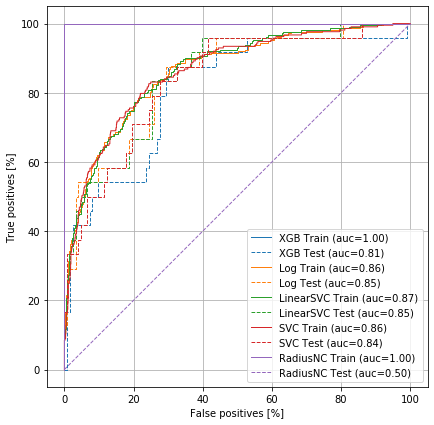

Stayers Detected (True Negatives):  123
Stayers Missed (False Positives):  0
Leavers Missed (False Negatives):  24
Leavers Detected (True Positives):  0


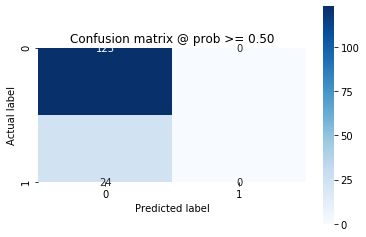

In [41]:
plt.figure(figsize=(7, 7))
plot_roc("XGB Train", train_labels, model_XGB.predict_proba(train_features)[:, 1], lcolor=colors[0], lwidth=1)
plot_roc("XGB Test", test_labels, model_XGB.predict_proba(test_features)[:, 1], lcolor=colors[0], lstyle='--', lwidth=1)

plot_roc("Log Train", train_labels, model_logistic.predict_proba(train_features)[:, 1], lcolor=colors[1], lwidth=1)
plot_roc("Log Test", test_labels, model_logistic.predict_proba(test_features)[:, 1], lcolor=colors[1], lstyle='--', lwidth=1)

plot_roc("LinearSVC Train", train_labels, model_LinearSVC.decision_function(train_features), lcolor=colors[2], lwidth=1)
plot_roc("LinearSVC Test", test_labels, model_LinearSVC.decision_function(test_features), lcolor=colors[2], lstyle='--', lwidth=1)

plot_roc("SVC Train", train_labels, model_SVC.predict_proba(train_features)[:, 1], lcolor=colors[3], lwidth=1)
plot_roc("SVC Test", test_labels, model_SVC.predict_proba(test_features)[:, 1], lcolor=colors[3], lstyle='--', lwidth=1)

plot_roc("RadiusNC Train", train_labels, model_RadiusNC.predict(train_features), lcolor=colors[4], lwidth=1)
plot_roc("RadiusNC Test", test_labels, model_RadiusNC.predict(test_features), lcolor=colors[4], lstyle='--', lwidth=1)
plt.legend(loc='lower right')
plt.show()

plot_cm(test_labels, model_RadiusNC.predict(test_features))

## 6. Random Forest Classifier

In [42]:
from sklearn.ensemble import RandomForestClassifier as RForest

### GridSearch with Stratified K-Fold CV

In [43]:
m_RF = RForest(criterion='gini',
               max_features='auto',
               class_weight=class_weights,
               n_jobs=6,
               random_state=0)

parameters = [{'n_estimators' : [100, 500, 1000],
               'max_depth' : [i for i in range(3,15,3)],
               'min_samples_split' : [i for i in range (2,4)], 
               'min_samples_leaf' : [i for i in range (2,4)],
               'warm_start' : [True, False]}]

grid_s = sklearn.model_selection.GridSearchCV(m_RF, parameters, n_jobs=6,
                                              cv=StratifiedKFold(n_splits=5, 
                                                                 shuffle=True),
                                              scoring='f1',
                                              refit=True,
                                              verbose=1)
grid_s.fit(train_features, train_labels)
print(grid_s.best_estimator_)
model_RandomForest = grid_s.best_estimator_

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    7.2s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:   34.8s
[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed:  1.5min
[Parallel(n_jobs=6)]: Done 480 out of 480 | elapsed:  1.6min finished


RandomForestClassifier(bootstrap=True,
                       class_weight={0: 0.595945945945946,
                                     1: 3.1056338028169015},
                       criterion='gini', max_depth=6, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=2,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=1000, n_jobs=6, oob_score=False,
                       random_state=0, verbose=0, warm_start=True)


In [44]:
models_summary = save_metrics(models_summary, model_RandomForest, test_labels, model_RandomForest.predict_proba(test_features)[:, 1])
models_summary.sort_values(by=['mc_coef', 'auc', 'prec'], ascending=False)

,model,tp,fp,tn,fn,acc,prec,recall,auc,f1,mc_coef,batch_s
2,"LinearSVC(C=1, class_weight={0: 0.595945945945...",11,4,119,13,0.884354,0.733333,0.458333,0.848238,0.564103,0.519930,NaN
0,"XGBClassifier(base_score=0.5, booster='gbtree'...",7,2,121,17,0.870748,0.777778,0.291667,0.811314,0.424242,0.424592,NaN
3,"SVC(C=7, cache_size=200,\n class_weight={0:...",6,1,122,18,0.870748,0.857143,0.250000,0.840447,0.387097,0.419785,NaN
5,"(DecisionTreeClassifier(class_weight=None, cri...",11,9,114,13,0.850340,0.550000,0.458333,0.794715,0.500000,0.415227,NaN
1,"LogisticRegression(C=1,\n cl...",16,30,93,8,0.741497,0.347826,0.666667,0.847222,0.457143,0.336990,NaN
4,"RadiusNeighborsClassifier(algorithm='auto', le...",0,0,123,24,0.836735,0.000000,0.000000,0.500000,0.000000,0.000000,NaN


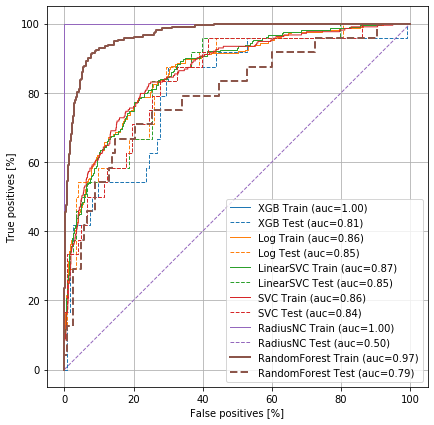

Stayers Detected (True Negatives):  114
Stayers Missed (False Positives):  9
Leavers Missed (False Negatives):  13
Leavers Detected (True Positives):  11


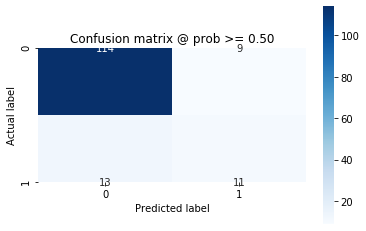

In [45]:
plt.figure(figsize=(7, 7))
plot_roc("XGB Train", train_labels, model_XGB.predict_proba(train_features)[:, 1], lcolor=colors[0], lwidth=1)
plot_roc("XGB Test", test_labels, model_XGB.predict_proba(test_features)[:, 1], lcolor=colors[0], lstyle='--', lwidth=1)

plot_roc("Log Train", train_labels, model_logistic.predict_proba(train_features)[:, 1], lcolor=colors[1], lwidth=1)
plot_roc("Log Test", test_labels, model_logistic.predict_proba(test_features)[:, 1], lcolor=colors[1], lstyle='--', lwidth=1)

plot_roc("LinearSVC Train", train_labels, model_LinearSVC.decision_function(train_features), lcolor=colors[2], lwidth=1)
plot_roc("LinearSVC Test", test_labels, model_LinearSVC.decision_function(test_features), lcolor=colors[2], lstyle='--', lwidth=1)

plot_roc("SVC Train", train_labels, model_SVC.predict_proba(train_features)[:, 1], lcolor=colors[3], lwidth=1)
plot_roc("SVC Test", test_labels, model_SVC.predict_proba(test_features)[:, 1], lcolor=colors[3], lstyle='--', lwidth=1)

plot_roc("RadiusNC Train", train_labels, model_RadiusNC.predict(train_features), lcolor=colors[4], lwidth=1)
plot_roc("RadiusNC Test", test_labels, model_RadiusNC.predict(test_features), lcolor=colors[4], lstyle='--', lwidth=1)

plot_roc("RandomForest Train", train_labels, model_RandomForest.predict_proba(train_features)[:, 1], lcolor=colors[5])
plot_roc("RandomForest Test", test_labels, model_RandomForest.predict_proba(test_features)[:, 1], lcolor=colors[5], lstyle='--')
plt.legend(loc='lower right')
plt.show()

plot_cm(test_labels, model_RandomForest.predict_proba(test_features)[:, 1])

## 7. Keras Tensorflow Classification NN

In [46]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [47]:
METRICS = [keras.metrics.Precision(name='precision'),
           keras.metrics.Recall(name='recall'),
           keras.metrics.AUC(name='auc')]

learn_rate = 0.001

if train_features.shape[-1]%2 == 0:
    n_init_neurons = train_features.shape[-1]+2
else:
    n_init_neurons = train_features.shape[-1]+1
    
print('The advisable number of neurons in the first layer should be: ', n_init_neurons)

The advisable number of neurons in the first layer should be:  44


In [48]:
def make_model(metrics = METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = keras.initializers.Constant(output_bias)
    model = keras.Sequential([
        keras.layers.Dense(train_features.shape[-1], activation=keras.layers.LeakyReLU(),
                           input_shape=(train_features.shape[-1],)),
        keras.layers.Dense(4, activation=keras.layers.LeakyReLU()), #best 5
        keras.layers.Dropout(0.25),
        keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias), # sigmoid for regressor with probability output
    ])

    # Designing NN:
    # https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw

    model.compile(
        optimizer=keras.optimizers.RMSprop(lr=learn_rate),
        #optimizer=keras.optimizers.Adam(lr=learn_rate),
        #optimizer=keras.optimizers.Nadam(lr=learn_rate),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=metrics)

    return model

In [49]:
EPOCHS = 100 # max number of epochs (the early stopping callback will cutoff before)
BATCH_SIZE = 64
#best batch size = 64, 70, 32, 128, 256

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    verbose=1,
    patience=15, #best 20
    restore_best_weights=True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.1,
    patience=5,
    cooldown=6,
    min_lr=0.00001)

In [50]:
model_keras = make_model()
model_keras.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 42)                1806      
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 172       
_________________________________________________________________
dropout (Dropout)            (None, 4)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5         
Total params: 1,983
Trainable params: 1,983
Non-trainable params: 0
_________________________________________________________________


In [51]:
#keras.utils.plot_model(model_keras)

In [52]:
train_nn_features, val_features, train_nn_labels, val_labels = train_test_split(train_features, train_labels, 
                                                                        test_size=0.2, 
                                                                        random_state=123, 
                                                                        stratify=train_labels)

neg, pos = np.bincount(train_nn_labels)

In [53]:
#Loss with correct initialization of bias
initial_bias = np.log([pos/neg])

model_keras = make_model(output_bias = initial_bias)

results = model_keras.evaluate(train_nn_features, train_nn_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.4472


In [54]:
#saving correct bias
initial_weights = os.path.join(tempfile.mkdtemp(),'initial_weights')
model_keras.save_weights(initial_weights)

### Baseline NN

In [55]:
model_keras = make_model()
model_keras.load_weights(initial_weights)

initial_weights = os.path.join(tempfile.mkdtemp(),'initial_weights')
model_keras.save_weights(initial_weights)

callback = [early_stopping, 
            reduce_lr]
baseline_history = model_keras.fit(train_nn_features,
                                    train_nn_labels,
                                    batch_size=BATCH_SIZE,
                                    epochs=EPOCHS,
                                    callbacks = callback,
                                    validation_data=(val_features, val_labels))


Train on 1058 samples, validate on 265 samples
Epoch 1/100
1058/1058 [==============================] - 2s 2ms/sample - loss: 0.4441 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5302 - val_loss: 0.4306 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6580
Epoch 2/100
1058/1058 [==============================] - 0s 93us/sample - loss: 0.4320 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6094 - val_loss: 0.4239 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6977
Epoch 3/100
1058/1058 [==============================] - 0s 94us/sample - loss: 0.4277 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6403 - val_loss: 0.4158 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7208
Epoch 4/100
1058/1058 [==============================] - 0s 105us/sample - loss: 0.4156 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6937 - val_loss: 0.4057 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7426
Epoch 5/1

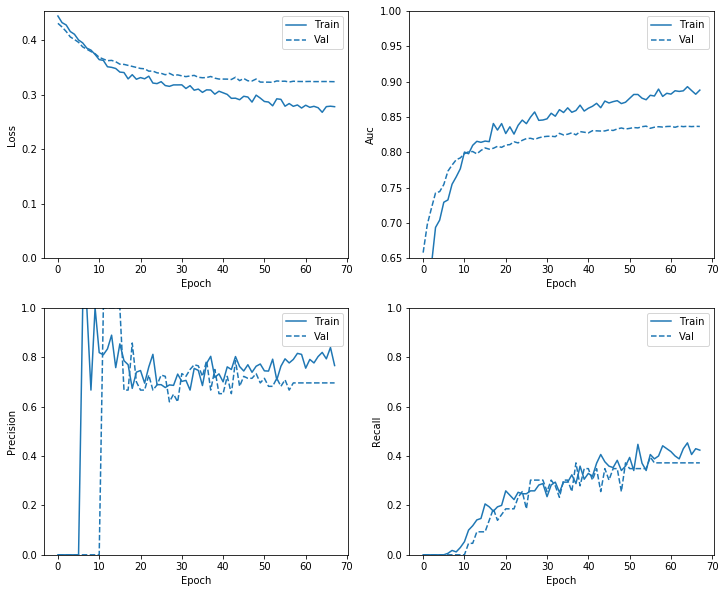

In [56]:
plot_nn_metrics(baseline_history)

In [57]:
train_predictions_baseline = model_keras.predict_proba(train_nn_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model_keras.predict_proba(test_features, batch_size=BATCH_SIZE)

loss :  0.3364380582862971
precision :  0.72727275
recall :  0.33333334
auc :  0.8277439

Stayers Detected (True Negatives):  120
Stayers Missed (False Positives):  3
Leavers Missed (False Negatives):  16
Leavers Detected (True Positives):  8


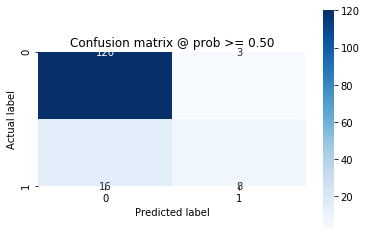

In [58]:
baseline_results = model_keras.evaluate(test_features, 
                                        test_labels,
                                        batch_size=BATCH_SIZE, 
                                        verbose=0)
for name, value in zip(model_keras.metrics_names, baseline_results):
    print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_baseline)

In [59]:
models_summary = save_metrics(models_summary, 'NN_base', test_labels, model_keras.predict_proba(test_features), batch_size=BATCH_SIZE)
models_summary.sort_values(by=['f1', 'recall'], ascending=False)

,model,tp,fp,tn,fn,acc,prec,recall,auc,f1,mc_coef,batch_s
2,"LinearSVC(C=1, class_weight={0: 0.595945945945...",11,4,119,13,0.884354,0.733333,0.458333,0.848238,0.564103,0.519930,NaN
5,"(DecisionTreeClassifier(class_weight=None, cri...",11,9,114,13,0.850340,0.550000,0.458333,0.794715,0.500000,0.415227,NaN
6,NN_base,8,3,120,16,0.870748,0.727273,0.333333,0.826558,0.457143,0.433981,64.0
1,"LogisticRegression(C=1,\n cl...",16,30,93,8,0.741497,0.347826,0.666667,0.847222,0.457143,0.336990,NaN
0,"XGBClassifier(base_score=0.5, booster='gbtree'...",7,2,121,17,0.870748,0.777778,0.291667,0.811314,0.424242,0.424592,NaN
3,"SVC(C=7, cache_size=200,\n class_weight={0:...",6,1,122,18,0.870748,0.857143,0.250000,0.840447,0.387097,0.419785,NaN
4,"RadiusNeighborsClassifier(algorithm='auto', le...",0,0,123,24,0.836735,0.000000,0.000000,0.500000,0.000000,0.000000,NaN


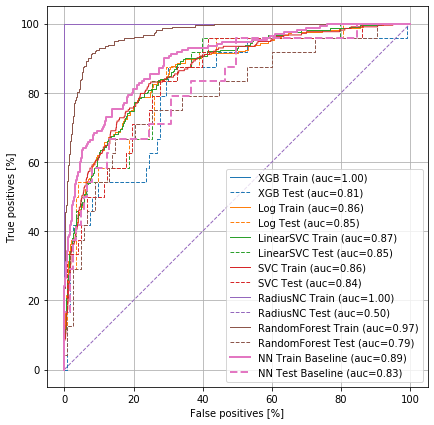

In [60]:
plt.figure(figsize=(7, 7))
plot_roc("XGB Train", train_labels, model_XGB.predict_proba(train_features)[:, 1], lcolor=colors[0], lwidth=1)
plot_roc("XGB Test", test_labels, model_XGB.predict_proba(test_features)[:, 1], lcolor=colors[0], lstyle='--', lwidth=1)

plot_roc("Log Train", train_labels, model_logistic.predict_proba(train_features)[:, 1], lcolor=colors[1], lwidth=1)
plot_roc("Log Test", test_labels, model_logistic.predict_proba(test_features)[:, 1], lcolor=colors[1], lstyle='--', lwidth=1)

plot_roc("LinearSVC Train", train_labels, model_LinearSVC.decision_function(train_features), lcolor=colors[2], lwidth=1)
plot_roc("LinearSVC Test", test_labels, model_LinearSVC.decision_function(test_features), lcolor=colors[2], lstyle='--', lwidth=1)

plot_roc("SVC Train", train_labels, model_SVC.predict_proba(train_features)[:, 1], lcolor=colors[3], lwidth=1)
plot_roc("SVC Test", test_labels, model_SVC.predict_proba(test_features)[:, 1], lcolor=colors[3], lstyle='--', lwidth=1)

plot_roc("RadiusNC Train", train_labels, model_RadiusNC.predict(train_features), lcolor=colors[4], lwidth=1)
plot_roc("RadiusNC Test", test_labels, model_RadiusNC.predict(test_features), lcolor=colors[4], lstyle='--', lwidth=1)

plot_roc("RandomForest Train", train_labels, model_RandomForest.predict_proba(train_features)[:, 1], lcolor=colors[5], lwidth=1)
plot_roc("RandomForest Test", test_labels, model_RandomForest.predict_proba(test_features)[:, 1], lcolor=colors[5], lstyle='--', lwidth=1)

plot_roc("NN Train Baseline", train_nn_labels, train_predictions_baseline, lcolor=colors[6])
plot_roc("NN Test Baseline", test_labels, test_predictions_baseline, lcolor=colors[6], lstyle='--')
plt.legend(loc='lower right')
plt.show()

### Weighted NN

In [61]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    train_nn_features,
    train_nn_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = [early_stopping, reduce_lr],
    validation_data=(val_features, val_labels),
    # The class weights go here
    class_weight=class_weights) 

Train on 1058 samples, validate on 265 samples
Epoch 1/100
1058/1058 [==============================] - 2s 2ms/sample - loss: 0.9125 - precision: 1.0000 - recall: 0.0059 - auc: 0.5022 - val_loss: 0.8077 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5669
Epoch 2/100
1058/1058 [==============================] - 0s 100us/sample - loss: 0.7878 - precision: 0.1795 - recall: 0.0824 - auc: 0.5170 - val_loss: 0.7352 - val_precision: 0.1429 - val_recall: 0.0233 - val_auc: 0.5840
Epoch 3/100
1058/1058 [==============================] - 0s 94us/sample - loss: 0.7395 - precision: 0.2067 - recall: 0.2176 - auc: 0.5497 - val_loss: 0.6960 - val_precision: 0.2368 - val_recall: 0.2093 - val_auc: 0.6053
Epoch 4/100
1058/1058 [==============================] - 0s 96us/sample - loss: 0.7339 - precision: 0.1966 - recall: 0.3353 - auc: 0.5363 - val_loss: 0.6822 - val_precision: 0.3889 - val_recall: 0.3256 - val_auc: 0.6513
Epoch 5/100
1058/1058 [==============================] - 0s 92us/

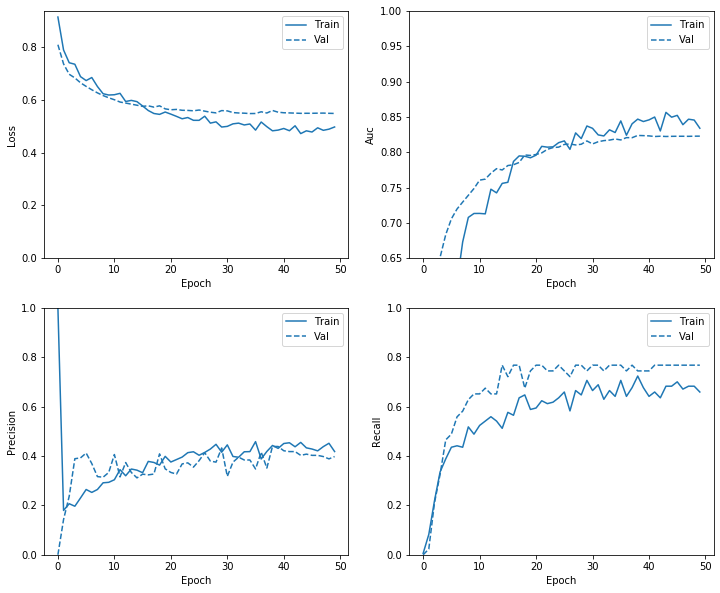

In [62]:
plot_nn_metrics(weighted_history)

In [63]:
train_predictions_weighted = weighted_model.predict_proba(train_nn_features, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict_proba(test_features, batch_size=BATCH_SIZE)

loss :  0.4406872697833444
precision :  0.43243244
recall :  0.6666667
auc :  0.8235095

Stayers Detected (True Negatives):  102
Stayers Missed (False Positives):  21
Leavers Missed (False Negatives):  8
Leavers Detected (True Positives):  16


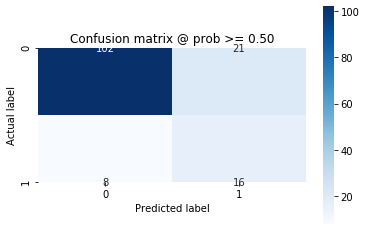

In [64]:
weighted_results = weighted_model.evaluate(test_features, test_labels,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_weighted)

In [65]:
models_summary = save_metrics(models_summary, 'NN_weighted', test_labels, weighted_model.predict_proba(test_features, batch_size=BATCH_SIZE), batch_size=BATCH_SIZE)

In [66]:
models_summary.sort_values(by=['f1', 
                               #'auc', 
                               'recall'], ascending=False)

,model,tp,fp,tn,fn,acc,prec,recall,auc,f1,mc_coef,batch_s
2,"LinearSVC(C=1, class_weight={0: 0.595945945945...",11,4,119,13,0.884354,0.733333,0.458333,0.848238,0.564103,0.519930,NaN
7,NN_weighted,16,21,102,8,0.802721,0.432432,0.666667,0.824187,0.524590,0.422363,64.0
5,"(DecisionTreeClassifier(class_weight=None, cri...",11,9,114,13,0.850340,0.550000,0.458333,0.794715,0.500000,0.415227,NaN
6,NN_base,8,3,120,16,0.870748,0.727273,0.333333,0.826558,0.457143,0.433981,64.0
1,"LogisticRegression(C=1,\n cl...",16,30,93,8,0.741497,0.347826,0.666667,0.847222,0.457143,0.336990,NaN
0,"XGBClassifier(base_score=0.5, booster='gbtree'...",7,2,121,17,0.870748,0.777778,0.291667,0.811314,0.424242,0.424592,NaN
3,"SVC(C=7, cache_size=200,\n class_weight={0:...",6,1,122,18,0.870748,0.857143,0.250000,0.840447,0.387097,0.419785,NaN
4,"RadiusNeighborsClassifier(algorithm='auto', le...",0,0,123,24,0.836735,0.000000,0.000000,0.500000,0.000000,0.000000,NaN


In [74]:
models_summary.sort_values(by=['f1', 
                               #'auc', 
                               'recall'], ascending=False).to_csv('preliminary_metrics_models_byf1score.csv')

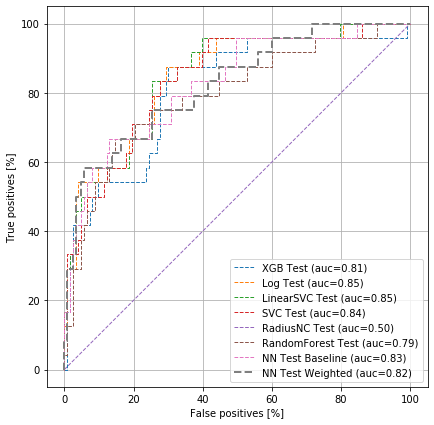

In [67]:
plt.figure(figsize=(7, 7))
plot_roc("XGB Test", test_labels, model_XGB.predict_proba(test_features)[:, 1], lcolor=colors[0], lstyle='--', lwidth=1)

plot_roc("Log Test", test_labels, model_logistic.predict_proba(test_features)[:, 1], lcolor=colors[1], lstyle='--', lwidth=1)

plot_roc("LinearSVC Test", test_labels, model_LinearSVC.decision_function(test_features), lcolor=colors[2], lstyle='--', lwidth=1)

plot_roc("SVC Test", test_labels, model_SVC.predict_proba(test_features)[:, 1], lcolor=colors[3], lstyle='--', lwidth=1)

plot_roc("RadiusNC Test", test_labels, model_RadiusNC.predict(test_features), lcolor=colors[4], lstyle='--', lwidth=1)

plot_roc("RandomForest Test", test_labels, model_RandomForest.predict_proba(test_features)[:, 1], lcolor=colors[5], lstyle='--', lwidth=1)

plot_roc("NN Test Baseline", test_labels, test_predictions_baseline, lcolor=colors[6], lstyle='--', lwidth=1)

plot_roc("NN Test Weighted", test_labels, test_predictions_weighted, lcolor=colors[7], lstyle='--')

plt.legend(loc='lower right')
plt.show()

# Further model exploration

## A. Confirmation of models with Stratified Kfold CV

## B. UpSampling with SMOTE

## C. Recursive Feature Selection with Stratified Kfold CV

Optimal number of features : 32


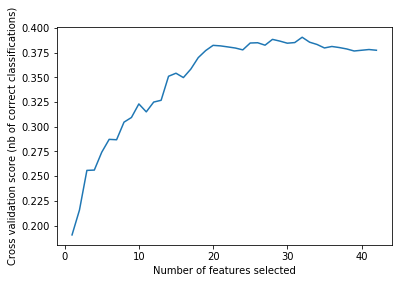

In [68]:
from sklearn.feature_selection import RFECV

# Logistic Model
rfecv = RFECV(estimator=model_logistic, step=1, cv=StratifiedKFold(3, shuffle=True, random_state=0),
              scoring='precision')
rfecv.fit(finaldf.drop(['Attrition_Yes'], axis=1), finaldf.Attrition_Yes)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

Optimal number of features : 29


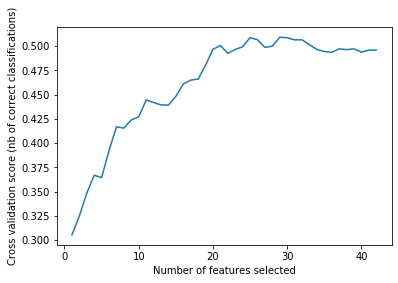

In [69]:
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

# LinearSVC Model
rfecv = RFECV(estimator=model_LinearSVC, step=1, cv=StratifiedKFold(3, shuffle=True, random_state=0),
              scoring='f1')
rfecv.fit(finaldf.drop(['Attrition_Yes'], axis=1), finaldf.Attrition_Yes)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

# Conclusion

In [70]:
models_summary[models_summary.prec > 0.4].sort_values(by=['f1','auc','mc_coef'], ascending=False).head(3)

,model,tp,fp,tn,fn,acc,prec,recall,auc,f1,mc_coef,batch_s
2,"LinearSVC(C=1, class_weight={0: 0.595945945945...",11,4,119,13,0.884354,0.733333,0.458333,0.848238,0.564103,0.519930,NaN
7,NN_weighted,16,21,102,8,0.802721,0.432432,0.666667,0.824187,0.524590,0.422363,64.0
5,"(DecisionTreeClassifier(class_weight=None, cri...",11,9,114,13,0.850340,0.550000,0.458333,0.794715,0.500000,0.415227,NaN


In [71]:
from scipy import stats
params = np.append(model_logistic.intercept_,model_logistic.coef_)
predictions = model_logistic.predict(test_features)

newX = pd.DataFrame({"Constant":np.ones(len(test_features))}).join(pd.DataFrame(test_features))
MSE = (sum((test_labels-predictions)**2))/(len(newX)-len(newX.columns))

var_b = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
sd_b = np.sqrt(var_b)
ts_b = params/ sd_b

p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newX)-1))) for i in ts_b]

sd_b = np.round(sd_b,3)
ts_b = np.round(ts_b,3)
p_values = np.round(p_values,3)
params = np.round(params,4)

myDF3 = pd.DataFrame()
myDF3["features"],myDF3["coef"],myDF3["se"],myDF3["t_values"],myDF3["p_value"] = [['']+test_df.columns.to_list(), params,sd_b,ts_b,p_values]
myDF3[myDF3['p_value'] < 0.05].sort_values(by=['coef'], ascending=False)

,features,coef,se,t_values,p_value
0,,2.5986,0.970,2.679,0.008
19,YearsSinceLastPromotion,1.9080,0.379,5.038,0.000
42,OverTime_Yes,1.5888,0.130,12.181,0.000
41,MaritalStatus_Single,1.1530,0.229,5.046,0.000
33,JobRole_LaboratoryTechnician,1.1320,0.228,4.969,0.000
3,DistanceFromHome,0.6922,0.217,3.190,0.002
40,MaritalStatus_Married,0.4689,0.166,2.829,0.005
31,Gender_Male,0.3368,0.119,2.821,0.005
2,DailyRate,-0.4264,0.202,-2.111,0.036
23,BusinessTravel_Rarely,-0.5487,0.165,-3.321,0.001


In [72]:
myDF3[myDF3['p_value'] > 0.05].sort_values(by=['coef'], ascending=False)

,features,coef,se,t_values,p_value
39,JobRole_SalesRepresentative,0.9966,0.531,1.875,0.063
17,YearsAtCompany,0.9737,0.906,1.075,0.284
32,JobRole_HumanResources,0.7035,0.910,0.773,0.441
25,Department_Sales,0.6517,0.978,0.666,0.506
30,EducationField_TechnicalDegree,0.5227,0.636,0.822,0.412
37,JobRole_ResearchScientist,0.3543,0.270,1.312,0.191
35,JobRole_ManufacturingDirector,0.3317,0.251,1.320,0.189
10,MonthlyRate,0.3270,0.204,1.601,0.111
38,JobRole_SalesExecutive,0.2106,0.464,0.454,0.650
9,MonthlyIncome,0.1968,0.617,0.319,0.750


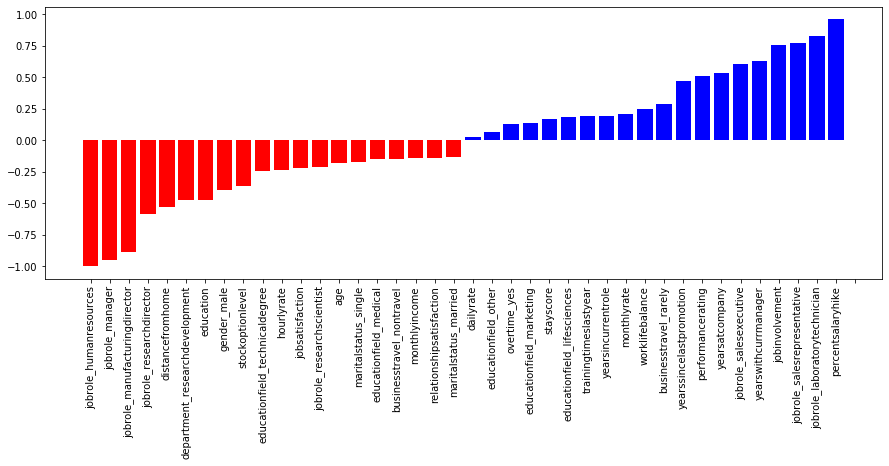

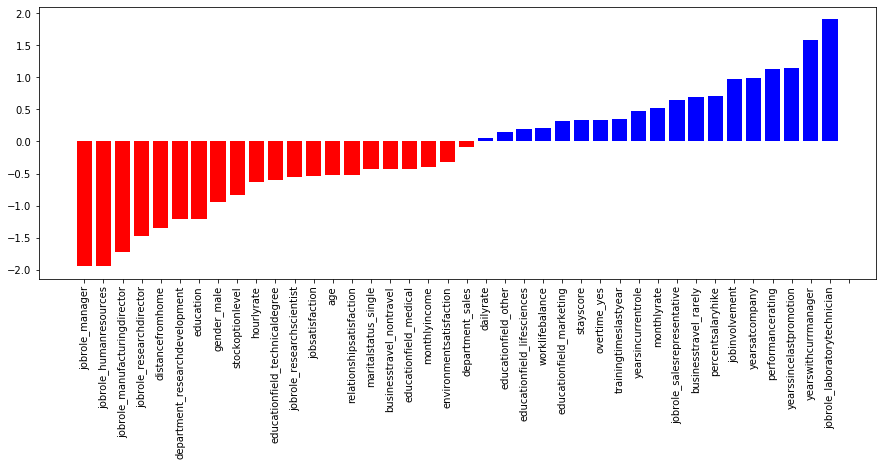

In [73]:
from sklearn.feature_extraction.text import CountVectorizer

def plot_coefficients(classifier, feature_names, top_features=20):
 coef = classifier.coef_.ravel()
 top_positive_coefficients = np.argsort(coef)[-top_features:]
 top_negative_coefficients = np.argsort(coef)[:top_features]
 top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
 # create plot
 plt.figure(figsize=(15, 5))
 colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
 plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
 feature_names = np.array(feature_names)
 plt.xticks(np.arange(0, 1 + 2 * top_features), feature_names[top_coefficients], rotation=90, ha='center')
 plt.show()

cv = CountVectorizer()
cv.fit(test_df)

plot_coefficients(model_LinearSVC, cv.get_feature_names())
plot_coefficients(model_logistic, cv.get_feature_names())